In [1]:
import  numpy as np
import random

# import tqdm: 这行代码导入了tqdm模块，它提供了一个用于在循环中显示进度条的功能。
# 这对于迭代大量数据或耗时的操作时，可以更直观地显示程序的运行进度。
import tqdm

import matplotlib.pyplot as plt
import pandas as pd

In [2]:
# 利用高斯距离法计算临近点的权重
# X,Y 模板大小，c 中心点的位置， sigma 影响半径
def gaussion_neighborhood(X,Y,c,sigma):
    
    # 使用 np.meshgrid 函数创建了一个二维网格，其中 xx 表示 x 轴方向上的坐标，yy 表示 y 轴方向上的坐标。
    # np.arange(X) 和 np.arange(Y) 分别生成了从 0 到 X-1 和从 0 到 Y-1 的一维数组，用于表示坐标轴上的位置。
    # 比如说模板是3*2（X*Y）
    # xx = [[0, 1, 2],
    #      [0, 1, 2]]
    # yy = [[0, 0, 0], 
    #      [1, 1, 1]]
    
    # xx 和 yy 的形状都是 (Y, X)，其中 Y 是模板的高度，X 是模板的宽度。
    # 在 xx 中，每个元素表示对应位置的 x 坐标，在 yy 中，每个元素表示对应位置的 y 坐标。
    # 对于一个给定的位置 (i, j)，我们可以使用 xx[i, j] 来获取其 x 坐标，使用 yy[i, j] 来获取其 y 坐标。

    xx,yy = np.meshgrid(np.arange(X),np.arange(Y))
    d = 2*sigma*sigma
    
    # xx-->(2*3) xx.T-->(3*2)  xx.T[c]-->（3*2的第c列，也就是有3个元素的一维数组（1*3））
    
    ax = np.exp(-np.power(xx-xx.T[c], 2)/d)
    ay = np.exp(-np.power(yy-yy.T[c], 2)/d)
    return (ax * ay).T

# 这个函数的作用是根据给定的模板大小、中心点位置和影响半径，计算临近点的权重，采用的是高斯距离法。权重计算的结果将作为函数的返回值。

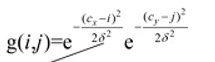

In [3]:
# 利用bubble距离法计算临近点的权重
# X,Y 模板大小，c 中心点的位置， sigma 影响半径
def bubble_neighborhood(X,Y,c,sigma):

    neigx = np.arange(X)
    neigY = np.arange(Y)
    
    ax = np.logical_and(neigx > c[0]-sigma,
                     neigx < c[0]+sigma)
    ay = np.logical_and(neigy > c[1]-sigma,
                     neigy < c[1]+sigma)
    return np.outer(ax, ay)*1.

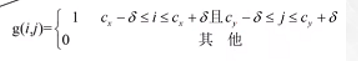

In [4]:
# 计算学习率
# lr 是初始学习率。 t 是当前训练步数。 max_steps 是总的训练步数。
def get_learning_rate(lr,t,max_steps):  
    return lr / (1+t/(max_steps/2))

# 这个函数用于动态调整学习率，通常在训练过程中，学习率会随着训练的进行而逐渐减小，以使得模型在训练后期更加稳定地收敛。

In [5]:
# 计算欧式距离
def euclidean_distance(x, w):
    dis = np.expand_dims(x,axis=(0,1))-w
    return np.linalg.norm(dis, axis=-1)

In [6]:
# 特征标准化 (x-mu)/std
def feature_normalization(data):
    mu = np.mean(data,axis=0,keepdims=True)
    sigma = np.std(data,axis=0,keepdims=True)
    return (data-mu)/sigma

# mu = np.mean(data, axis=0, keepdims=True) 计算 data 沿着轴 0（列）方向的均值。keepdims=True 保持结果的维度与原始数据一致，得到一个形状为 (1, num_features) 的数组，其中 num_features 是特征的数量。
# sigma = np.std(data, axis=0, keepdims=True) 计算 data 沿着轴 0（列）方向的标准差。keepdims=True 保持结果的维度与原始数据一致，得到一个形状为 (1, num_features) 的数组。
# (data - mu) / sigma 对数据进行标准化处理，即将每个特征减去其均值并除以标准差。这将得到一个形状与 data 相同的数组，其中每个特征都经过了标准化处理。
# 函数返回值是经过特征标准化处理后的数据，其形状与输入数据 data 一致。

In [7]:
# 获取激活节点的位置
def get_winner_index(x,w,dis_fun=euclidean_distance):
    # 计算输入样本和各个节点的距离
    dis = dis_fun(x,w)
    
    # 找到距离最小的位置
    index = np.where(dis==np.min(dis))
    return (index[0][0],index[1][0])

In [8]:
def weights_PCA(X,Y,data):
    
    N,D = np.shape(data)
    weights = np.zeros([X,Y,D])
    
    pc_length, pc = np.linalg.eig(np.cov(np.transpose(data)))
    pc_order = np.argsort(-pc_length)
    for i, c1 in enumerate(np.linspace(-1, 1, X)):
        for j, c2 in enumerate(np.linspace(-1, 1, Y)):
            weights[i, j] = c1*pc[pc_order[0]] + c2*pc[pc_order[1]]
    return weights

# np.transpose(data) 对输入数据进行转置，使得每一列表示一个特征。
# np.cov 计算转置后的数据矩阵的协方差矩阵，表示特征之间的相关性。
# np.linalg.eig 对协方差矩阵进行特征值分解，得到特征值和对应的特征向量。pc_length 是特征值的数组，pc 是特征向量组成的矩阵。
# np.argsort(-pc_length) 返回特征值降序排序后的索引数组，即主成分的顺序。
# 使用 np.linspace 函数生成在 [-1, 1] 范围内均匀分布的值，用作权重矩阵的系数。
# 循环遍历权重矩阵的索引，根据主成分和权重矩阵的尺寸，通过线性组合主成分得到权重矩阵的每个元素。
# 返回生成的权重矩阵。

In [9]:
# 计算量化误差
def get_quantization_error(datas,weights):
    w_x, w_y = zip(*[get_winner_index(d,weights) for d in datas])
    error = datas - weights[w_x,w_y]
    error = np.linalg.norm(error, axis=-1)
    return np.mean(error)

# w_x, w_y = zip(*[get_winner_index(d, weights) for d in datas]) 通过调用 get_winner_index 函数，
# 找到每个输入向量的最优匹配单元（即激活节点）在权重矩阵中的位置。w_x 和 w_y 分别表示最优匹配单元的行索引和列索引。
# error = datas - weights[w_x, w_y] 通过将输入向量与对应的最优匹配单元的权重值相减，计算每个输入向量的量化误差。
# 这里使用了广播机制，使得维度匹配，可以直接相减。
# error = np.linalg.norm(error, axis=-1) 计算每个输入向量的量化误差的欧式范数。
# np.linalg.norm 函数用于计算向量的范数，这里指定 axis=-1 表示沿最后一个轴（特征维度）计算范数。
# return np.mean(error) 返回量化误差的平均值，即所有输入向量的量化误差的平均值。
# 该函数通过找到每个输入向量的最优匹配单元，并计算其与最优匹配单元的权重之间的差异，从而得到输入向量的量化误差。
# 然后，通过计算量化误差的平均值，得到对整个数据集的量化误差的度量。

In [10]:
# X 和 Y 是自组织映射网络的网格尺寸。
# N_epoch 是训练的迭代次数。
# datas 是输入数据集，每行表示一个样本。
# init_lr 是初始学习率。
# sigma 是影响半径的初始值。
# dis_fun 是计算样本和权重之间距离的函数，默认为欧式距离。
# neighborhood_fun 是计算临近点权重的函数，默认为高斯邻域函数。
# init_weight_fun 是用于初始化权重矩阵的函数，如果为None，则使用随机初始化。
# seed 是随机种子，用于控制随机初始化的结果的重现性。
def train_SOM(X,
              Y,
              N_epoch,
              datas,
              init_lr = 0.5,
              sigma =0.5,
              dis_fun=euclidean_distance,
              neighborhood_fun=gaussion_neighborhood,
              init_weight_fun = None,
              seed =20):
    
    # 获取输入特征的维度
    N,D = np.shape(datas)
    
    # 训练的步数
    # 训练的步数 N_steps 表示在整个训练过程中的总步数。
    # 它是迭代次数乘以数据集的大小 N。每一步都代表对训练集中的一个样本进行一次权重更新。
    # 总步数表示训练过程中权重更新的总次数。
    N_steps = N_epoch*N
    
    # 对权重进行初始化
    
    # 用于创建一个随机数生成器对象，将生成的随机数生成器对象赋值给变量 rng，然后在后续的代码中使用该对象来生成随机数。
    rng  =  np.random.RandomState(seed)
    
    # rng.rand(X, Y, D) 生成一个形状为 (X, Y, D) 的随机数数组。这里使用了 rng.rand() 函数来生成在 [0, 1) 范围内均匀分布的随机数。
    # *2-1 将随机数数组中的值乘以 2，并减去 1，将数值范围映射到 [-1, 1)。
    # weights /= np.linalg.norm(weights, axis=-1, keepdims=True) 对权重矩阵进行归一化处理。
    # np.linalg.norm() 函数计算数组的范数，axis=-1 表示沿着最后一个轴（特征维度）计算范数。
    # 这里将每个权重向量除以其欧式范数，从而使其长度归一化为 1。
    # 通过这些步骤，实现了对权重矩阵的随机初始化并进行归一化处理，以便在训练过程中进行权重更新和调整。
    if init_weight_fun is None:
        weights = rng.rand(X, Y, D)*2-1
        weights /= np.linalg.norm(weights, axis=-1, keepdims=True)
    else:
        weights = init_weight_fun(X,Y,datas)
    
 
    for n_epoch in range(N_epoch):
        print("Epoch %d"%(n_epoch+1))
        
        # 打乱次序
        # np.arange(N) 创建一个包含从 0 到 N-1 的整数序列，其中 N 是数据集的大小。
        # rng.permutation() 函数将这个整数序列进行随机打乱，生成一个新的随机顺序的整数序列。
        # 将打乱后的整数序列赋值给变量 index。
        # 通过这个步骤，可以实现在每个训练周期中以随机顺序遍历训练数据集，从而使模型在不同的样本顺序下进行训练，增加训练的随机性和泛化能力。
        index = rng.permutation(np.arange(N))
        
        # 在每个训练步骤中，使用 enumerate(index) 迭代打乱后的索引序列，其中 index 是之前通过打乱次序得到的随机索引序列。
        # 在每次迭代中，获取当前迭代步骤的索引和对应的样本 _id。
        # 使用 _id 作为索引，从输入数据集 datas 中获取对应的样本 x。
        # 在后续的训练过程中，可以使用样本 x 来更新权重和进行其他训练操作。
        # 通过这个步骤，每个训练步骤都会从打乱后的数据集中按照随机顺序获取一个样本进行训练。
        # 这样可以确保在每个步骤中都能够涵盖不同的样本，增加训练的多样性和泛化能力。
        for n_step,_id in enumerate(index):
            
            # 取一个样本
            x = datas[_id]
            
            # 计算learning rate(eta)
            t = N*n_epoch+n_step
            eta = get_learning_rate(init_lr,t,N_steps)
            
            # 计算样本距离每个顶点的距离,并获得激活点的位置
            winner = get_winner_index(x,weights,dis_fun)
            
            # 根据激活点的位置计算临近点的权重
            new_sigma = get_learning_rate(sigma,t,N_steps)
            g = neighborhood_fun(X,Y,winner,new_sigma)
            g = g*eta
            
            # 进行权重的更新         
            weights = weights + np.expand_dims(g,-1)*(x-weights)
            
        # 打印量化误差
        print("quantization_error= %.4f"%(get_quantization_error(datas,weights)))
        
    return weights
         

In [11]:
def get_U_Matrix(weights):
    
    X,Y,D = np.shape(weights)
    
    # (X, Y, 8) 指定了数组 um 的形状，其中 X 表示高度，Y 表示宽度，8 表示深度。
    # np.zeros((X, Y, 8)) 创建了一个全零的数组，形状为 (X, Y, 8)。
    # np.nan * np.zeros((X, Y, 8)) 将全零数组的每个元素乘以 nan 值，即将数组中的所有元素初始化为 nan。
    # 通过这个步骤，创建了一个形状为 (X, Y, 8) 的数组 um，其中所有元素均为 nan 值。
    # 这样初始化的目的是为了后续的计算过程中能够将有效的值存储在相应的位置，而无效的位置保持为 nan 值。
    um = np.nan * np.zeros((X,Y,8)) # 8邻域
    
    ii = [0, -1, -1, -1, 0, 1, 1, 1]   
    jj = [-1, -1, 0, 1, 1, 1, 0, -1]   
    
    for x in range(X):
        for y in range(Y):
            w_2 = weights[x, y]
            
            for k, (i, j) in enumerate(zip(ii, jj)):
                if (x+i >= 0 and x+i < X and y+j >= 0 and y+j < Y):
                    w_1 = weights[x+i, y+j]
                    um[x, y, k] = np.linalg.norm(w_1-w_2)

    
    um = np.nansum(um, axis=2)
    return um/um.max()

# 定义U-Matrix数组：首先，根据权重矩阵的形状（X、Y和D），创建一个形状为（X，Y，8）的数组um。这个数组将用于存储U-Matrix的结果。
# 在初始化时，所有元素都被设置为nan（非数字）值，以标记无效的位置。

# 定义8邻域偏移量：定义两个数组ii和jj，分别包含了8邻域的x和y方向的偏移量。这些偏移量用于确定每个节点的8个邻居节点。

# 计算节点之间的差异：通过嵌套的for循环遍历权重矩阵的每个节点（x和y）。对于每个节点，获取其对应的权重值w_2。

# 计算邻居节点之间的差异：通过另一个嵌套的for循环遍历8邻域偏移量ii和jj中的每个偏移值（i和j）。
# 根据当前节点的位置（x和y）和偏移值（i和j），确定邻居节点的位置（x+i和y+j）。
# 如果邻居节点的位置在有效范围内（即不超出权重矩阵的边界），则获取该邻居节点的权重值w_1。

# 计算节点之间的欧氏距离：使用numpy的linalg.norm函数计算当前节点（w_2）和邻居节点（w_1）之间的欧氏距离，
# 并将结果存储在U-Matrix数组的相应位置（um[x, y, k]）。

# 计算U-Matrix值：通过沿深度轴（axis=2）对U-Matrix数组进行求和，得到每个节点的U值。
# 然后，将U值除以U值的最大值，以将U-Matrix归一化为0到1的范围。

# 最终，函数返回计算得到的U-Matrix数组。

210 7
Epoch 1
quantization_error= 0.8605
Epoch 2
quantization_error= 0.7922
Epoch 3
quantization_error= 0.7394
Epoch 4
quantization_error= 0.7811
Epoch 5
quantization_error= 0.8060
Epoch 6
quantization_error= 0.7886
Epoch 7
quantization_error= 0.8575
Epoch 8
quantization_error= 0.8507
Epoch 9
quantization_error= 0.8606
Epoch 10
quantization_error= 0.8135
Epoch 11
quantization_error= 0.8278
Epoch 12
quantization_error= 0.8155
Epoch 13
quantization_error= 0.8962
Epoch 14
quantization_error= 0.9160
Epoch 15
quantization_error= 0.8328
Epoch 16
quantization_error= 0.8081
Epoch 17
quantization_error= 0.7726
Epoch 18
quantization_error= 0.7897
Epoch 19
quantization_error= 0.7594
Epoch 20
quantization_error= 0.8197
Epoch 21
quantization_error= 0.7950
Epoch 22
quantization_error= 0.8279
Epoch 23
quantization_error= 0.7856
Epoch 24
quantization_error= 0.8008
Epoch 25
quantization_error= 0.7943
Epoch 26
quantization_error= 0.8099
Epoch 27
quantization_error= 0.8609
Epoch 28
quantization_error= 0.

quantization_error= 0.8173
Epoch 229
quantization_error= 0.7668
Epoch 230
quantization_error= 0.8066
Epoch 231
quantization_error= 0.8379
Epoch 232
quantization_error= 0.7215
Epoch 233
quantization_error= 0.7805
Epoch 234
quantization_error= 0.7627
Epoch 235
quantization_error= 0.7939
Epoch 236
quantization_error= 0.7708
Epoch 237
quantization_error= 0.7933
Epoch 238
quantization_error= 0.7388
Epoch 239
quantization_error= 0.8029
Epoch 240
quantization_error= 0.7890
Epoch 241
quantization_error= 0.8012
Epoch 242
quantization_error= 0.8217
Epoch 243
quantization_error= 0.7985
Epoch 244
quantization_error= 0.8015
Epoch 245
quantization_error= 0.8265
Epoch 246
quantization_error= 0.7661
Epoch 247
quantization_error= 0.7948
Epoch 248
quantization_error= 0.7689
Epoch 249
quantization_error= 0.8066
Epoch 250
quantization_error= 0.8138
Epoch 251
quantization_error= 0.7768
Epoch 252
quantization_error= 0.7743
Epoch 253
quantization_error= 0.7349
Epoch 254
quantization_error= 0.8095
Epoch 255
q

quantization_error= 0.7789
Epoch 451
quantization_error= 0.7585
Epoch 452
quantization_error= 0.7476
Epoch 453
quantization_error= 0.7783
Epoch 454
quantization_error= 0.7666
Epoch 455
quantization_error= 0.7600
Epoch 456
quantization_error= 0.7611
Epoch 457
quantization_error= 0.7790
Epoch 458
quantization_error= 0.7608
Epoch 459
quantization_error= 0.7878
Epoch 460
quantization_error= 0.7437
Epoch 461
quantization_error= 0.7644
Epoch 462
quantization_error= 0.7719
Epoch 463
quantization_error= 0.7925
Epoch 464
quantization_error= 0.8170
Epoch 465
quantization_error= 0.7988
Epoch 466
quantization_error= 0.7875
Epoch 467
quantization_error= 0.7752
Epoch 468
quantization_error= 0.7681
Epoch 469
quantization_error= 0.7614
Epoch 470
quantization_error= 0.7686
Epoch 471
quantization_error= 0.7426
Epoch 472
quantization_error= 0.7275
Epoch 473
quantization_error= 0.7838
Epoch 474
quantization_error= 0.7748
Epoch 475
quantization_error= 0.7743
Epoch 476
quantization_error= 0.8104
Epoch 477
q

quantization_error= 0.7143
Epoch 673
quantization_error= 0.7213
Epoch 674
quantization_error= 0.7623
Epoch 675
quantization_error= 0.7252
Epoch 676
quantization_error= 0.7630
Epoch 677
quantization_error= 0.7155
Epoch 678
quantization_error= 0.7522
Epoch 679
quantization_error= 0.8197
Epoch 680
quantization_error= 0.7736
Epoch 681
quantization_error= 0.7613
Epoch 682
quantization_error= 0.7817
Epoch 683
quantization_error= 0.7488
Epoch 684
quantization_error= 0.7283
Epoch 685
quantization_error= 0.7707
Epoch 686
quantization_error= 0.7842
Epoch 687
quantization_error= 0.7629
Epoch 688
quantization_error= 0.7789
Epoch 689
quantization_error= 0.7308
Epoch 690
quantization_error= 0.7415
Epoch 691
quantization_error= 0.7210
Epoch 692
quantization_error= 0.7296
Epoch 693
quantization_error= 0.7285
Epoch 694
quantization_error= 0.8007
Epoch 695
quantization_error= 0.7570
Epoch 696
quantization_error= 0.7601
Epoch 697
quantization_error= 0.7803
Epoch 698
quantization_error= 0.7380
Epoch 699
q

quantization_error= 0.7352
Epoch 899
quantization_error= 0.7704
Epoch 900
quantization_error= 0.7743
Epoch 901
quantization_error= 0.7616
Epoch 902
quantization_error= 0.7471
Epoch 903
quantization_error= 0.7545
Epoch 904
quantization_error= 0.7165
Epoch 905
quantization_error= 0.7690
Epoch 906
quantization_error= 0.7555
Epoch 907
quantization_error= 0.7457
Epoch 908
quantization_error= 0.7346
Epoch 909
quantization_error= 0.7623
Epoch 910
quantization_error= 0.7500
Epoch 911
quantization_error= 0.7427
Epoch 912
quantization_error= 0.7709
Epoch 913
quantization_error= 0.7597
Epoch 914
quantization_error= 0.7502
Epoch 915
quantization_error= 0.7352
Epoch 916
quantization_error= 0.7369
Epoch 917
quantization_error= 0.7295
Epoch 918
quantization_error= 0.7438
Epoch 919
quantization_error= 0.7767
Epoch 920
quantization_error= 0.7475
Epoch 921
quantization_error= 0.7628
Epoch 922
quantization_error= 0.7365
Epoch 923
quantization_error= 0.7327
Epoch 924
quantization_error= 0.7256
Epoch 925
q

quantization_error= 0.7203
Epoch 1119
quantization_error= 0.7433
Epoch 1120
quantization_error= 0.7864
Epoch 1121
quantization_error= 0.7519
Epoch 1122
quantization_error= 0.7380
Epoch 1123
quantization_error= 0.7186
Epoch 1124
quantization_error= 0.7538
Epoch 1125
quantization_error= 0.7123
Epoch 1126
quantization_error= 0.7497
Epoch 1127
quantization_error= 0.7307
Epoch 1128
quantization_error= 0.7375
Epoch 1129
quantization_error= 0.7203
Epoch 1130
quantization_error= 0.7262
Epoch 1131
quantization_error= 0.7351
Epoch 1132
quantization_error= 0.7341
Epoch 1133
quantization_error= 0.7046
Epoch 1134
quantization_error= 0.7600
Epoch 1135
quantization_error= 0.7334
Epoch 1136
quantization_error= 0.7287
Epoch 1137
quantization_error= 0.7373
Epoch 1138
quantization_error= 0.7334
Epoch 1139
quantization_error= 0.7315
Epoch 1140
quantization_error= 0.6983
Epoch 1141
quantization_error= 0.7236
Epoch 1142
quantization_error= 0.7260
Epoch 1143
quantization_error= 0.7416
Epoch 1144
quantization

quantization_error= 0.7287
Epoch 1335
quantization_error= 0.7195
Epoch 1336
quantization_error= 0.7116
Epoch 1337
quantization_error= 0.6947
Epoch 1338
quantization_error= 0.6929
Epoch 1339
quantization_error= 0.7391
Epoch 1340
quantization_error= 0.7119
Epoch 1341
quantization_error= 0.7341
Epoch 1342
quantization_error= 0.7182
Epoch 1343
quantization_error= 0.6898
Epoch 1344
quantization_error= 0.7144
Epoch 1345
quantization_error= 0.7266
Epoch 1346
quantization_error= 0.7150
Epoch 1347
quantization_error= 0.7171
Epoch 1348
quantization_error= 0.7131
Epoch 1349
quantization_error= 0.6967
Epoch 1350
quantization_error= 0.7138
Epoch 1351
quantization_error= 0.7217
Epoch 1352
quantization_error= 0.7150
Epoch 1353
quantization_error= 0.7084
Epoch 1354
quantization_error= 0.7155
Epoch 1355
quantization_error= 0.6912
Epoch 1356
quantization_error= 0.7218
Epoch 1357
quantization_error= 0.7055
Epoch 1358
quantization_error= 0.6979
Epoch 1359
quantization_error= 0.6980
Epoch 1360
quantization

quantization_error= 0.7196
Epoch 1555
quantization_error= 0.7237
Epoch 1556
quantization_error= 0.7152
Epoch 1557
quantization_error= 0.7179
Epoch 1558
quantization_error= 0.7236
Epoch 1559
quantization_error= 0.7002
Epoch 1560
quantization_error= 0.6988
Epoch 1561
quantization_error= 0.7150
Epoch 1562
quantization_error= 0.6882
Epoch 1563
quantization_error= 0.7038
Epoch 1564
quantization_error= 0.7057
Epoch 1565
quantization_error= 0.6985
Epoch 1566
quantization_error= 0.6731
Epoch 1567
quantization_error= 0.6949
Epoch 1568
quantization_error= 0.7101
Epoch 1569
quantization_error= 0.7386
Epoch 1570
quantization_error= 0.7169
Epoch 1571
quantization_error= 0.6882
Epoch 1572
quantization_error= 0.7133
Epoch 1573
quantization_error= 0.7711
Epoch 1574
quantization_error= 0.6929
Epoch 1575
quantization_error= 0.6933
Epoch 1576
quantization_error= 0.7079
Epoch 1577
quantization_error= 0.6841
Epoch 1578
quantization_error= 0.7060
Epoch 1579
quantization_error= 0.6978
Epoch 1580
quantization

quantization_error= 0.6822
Epoch 1775
quantization_error= 0.7176
Epoch 1776
quantization_error= 0.6875
Epoch 1777
quantization_error= 0.6640
Epoch 1778
quantization_error= 0.6883
Epoch 1779
quantization_error= 0.6953
Epoch 1780
quantization_error= 0.6584
Epoch 1781
quantization_error= 0.6827
Epoch 1782
quantization_error= 0.6834
Epoch 1783
quantization_error= 0.6741
Epoch 1784
quantization_error= 0.6983
Epoch 1785
quantization_error= 0.6824
Epoch 1786
quantization_error= 0.6710
Epoch 1787
quantization_error= 0.6771
Epoch 1788
quantization_error= 0.6978
Epoch 1789
quantization_error= 0.6720
Epoch 1790
quantization_error= 0.6912
Epoch 1791
quantization_error= 0.6694
Epoch 1792
quantization_error= 0.6956
Epoch 1793
quantization_error= 0.6781
Epoch 1794
quantization_error= 0.6945
Epoch 1795
quantization_error= 0.6695
Epoch 1796
quantization_error= 0.6626
Epoch 1797
quantization_error= 0.6952
Epoch 1798
quantization_error= 0.6626
Epoch 1799
quantization_error= 0.6784
Epoch 1800
quantization

quantization_error= 0.6505
Epoch 1994
quantization_error= 0.6971
Epoch 1995
quantization_error= 0.6710
Epoch 1996
quantization_error= 0.6841
Epoch 1997
quantization_error= 0.6818
Epoch 1998
quantization_error= 0.6802
Epoch 1999
quantization_error= 0.6610
Epoch 2000
quantization_error= 0.6718
Epoch 2001
quantization_error= 0.6734
Epoch 2002
quantization_error= 0.6674
Epoch 2003
quantization_error= 0.6841
Epoch 2004
quantization_error= 0.6692
Epoch 2005
quantization_error= 0.7007
Epoch 2006
quantization_error= 0.6621
Epoch 2007
quantization_error= 0.6730
Epoch 2008
quantization_error= 0.6611
Epoch 2009
quantization_error= 0.6808
Epoch 2010
quantization_error= 0.6558
Epoch 2011
quantization_error= 0.7054
Epoch 2012
quantization_error= 0.6982
Epoch 2013
quantization_error= 0.7003
Epoch 2014
quantization_error= 0.6738
Epoch 2015
quantization_error= 0.6852
Epoch 2016
quantization_error= 0.6886
Epoch 2017
quantization_error= 0.6732
Epoch 2018
quantization_error= 0.6694
Epoch 2019
quantization

quantization_error= 0.6574
Epoch 2210
quantization_error= 0.6575
Epoch 2211
quantization_error= 0.6617
Epoch 2212
quantization_error= 0.6594
Epoch 2213
quantization_error= 0.6925
Epoch 2214
quantization_error= 0.6565
Epoch 2215
quantization_error= 0.6624
Epoch 2216
quantization_error= 0.6789
Epoch 2217
quantization_error= 0.6777
Epoch 2218
quantization_error= 0.6633
Epoch 2219
quantization_error= 0.6806
Epoch 2220
quantization_error= 0.6474
Epoch 2221
quantization_error= 0.6671
Epoch 2222
quantization_error= 0.6764
Epoch 2223
quantization_error= 0.6860
Epoch 2224
quantization_error= 0.6796
Epoch 2225
quantization_error= 0.6826
Epoch 2226
quantization_error= 0.6706
Epoch 2227
quantization_error= 0.6768
Epoch 2228
quantization_error= 0.6678
Epoch 2229
quantization_error= 0.6537
Epoch 2230
quantization_error= 0.6345
Epoch 2231
quantization_error= 0.6723
Epoch 2232
quantization_error= 0.6767
Epoch 2233
quantization_error= 0.6716
Epoch 2234
quantization_error= 0.6726
Epoch 2235
quantization

quantization_error= 0.6554
Epoch 2426
quantization_error= 0.6751
Epoch 2427
quantization_error= 0.6612
Epoch 2428
quantization_error= 0.6796
Epoch 2429
quantization_error= 0.6680
Epoch 2430
quantization_error= 0.6606
Epoch 2431
quantization_error= 0.6615
Epoch 2432
quantization_error= 0.6545
Epoch 2433
quantization_error= 0.6451
Epoch 2434
quantization_error= 0.6651
Epoch 2435
quantization_error= 0.6648
Epoch 2436
quantization_error= 0.6690
Epoch 2437
quantization_error= 0.6593
Epoch 2438
quantization_error= 0.6663
Epoch 2439
quantization_error= 0.6730
Epoch 2440
quantization_error= 0.6652
Epoch 2441
quantization_error= 0.6441
Epoch 2442
quantization_error= 0.6471
Epoch 2443
quantization_error= 0.6529
Epoch 2444
quantization_error= 0.6644
Epoch 2445
quantization_error= 0.6714
Epoch 2446
quantization_error= 0.6625
Epoch 2447
quantization_error= 0.6630
Epoch 2448
quantization_error= 0.6551
Epoch 2449
quantization_error= 0.6586
Epoch 2450
quantization_error= 0.6681
Epoch 2451
quantization

quantization_error= 0.6654
Epoch 2647
quantization_error= 0.6610
Epoch 2648
quantization_error= 0.6472
Epoch 2649
quantization_error= 0.6396
Epoch 2650
quantization_error= 0.6565
Epoch 2651
quantization_error= 0.6536
Epoch 2652
quantization_error= 0.6336
Epoch 2653
quantization_error= 0.6547
Epoch 2654
quantization_error= 0.6338
Epoch 2655
quantization_error= 0.6641
Epoch 2656
quantization_error= 0.6434
Epoch 2657
quantization_error= 0.6590
Epoch 2658
quantization_error= 0.6573
Epoch 2659
quantization_error= 0.6492
Epoch 2660
quantization_error= 0.6590
Epoch 2661
quantization_error= 0.6579
Epoch 2662
quantization_error= 0.6497
Epoch 2663
quantization_error= 0.6355
Epoch 2664
quantization_error= 0.6523
Epoch 2665
quantization_error= 0.6376
Epoch 2666
quantization_error= 0.6422
Epoch 2667
quantization_error= 0.6453
Epoch 2668
quantization_error= 0.6386
Epoch 2669
quantization_error= 0.6543
Epoch 2670
quantization_error= 0.6582
Epoch 2671
quantization_error= 0.6453
Epoch 2672
quantization

quantization_error= 0.6364
Epoch 2866
quantization_error= 0.6506
Epoch 2867
quantization_error= 0.6449
Epoch 2868
quantization_error= 0.6340
Epoch 2869
quantization_error= 0.6410
Epoch 2870
quantization_error= 0.6463
Epoch 2871
quantization_error= 0.6538
Epoch 2872
quantization_error= 0.6457
Epoch 2873
quantization_error= 0.6262
Epoch 2874
quantization_error= 0.6391
Epoch 2875
quantization_error= 0.6417
Epoch 2876
quantization_error= 0.6470
Epoch 2877
quantization_error= 0.6315
Epoch 2878
quantization_error= 0.6459
Epoch 2879
quantization_error= 0.6429
Epoch 2880
quantization_error= 0.6458
Epoch 2881
quantization_error= 0.6487
Epoch 2882
quantization_error= 0.6413
Epoch 2883
quantization_error= 0.6400
Epoch 2884
quantization_error= 0.6408
Epoch 2885
quantization_error= 0.6382
Epoch 2886
quantization_error= 0.6384
Epoch 2887
quantization_error= 0.6260
Epoch 2888
quantization_error= 0.6518
Epoch 2889
quantization_error= 0.6448
Epoch 2890
quantization_error= 0.6291
Epoch 2891
quantization

quantization_error= 0.6282
Epoch 3086
quantization_error= 0.6253
Epoch 3087
quantization_error= 0.6351
Epoch 3088
quantization_error= 0.6414
Epoch 3089
quantization_error= 0.6405
Epoch 3090
quantization_error= 0.6202
Epoch 3091
quantization_error= 0.6343
Epoch 3092
quantization_error= 0.6368
Epoch 3093
quantization_error= 0.6423
Epoch 3094
quantization_error= 0.6423
Epoch 3095
quantization_error= 0.6433
Epoch 3096
quantization_error= 0.6313
Epoch 3097
quantization_error= 0.6331
Epoch 3098
quantization_error= 0.6416
Epoch 3099
quantization_error= 0.6437
Epoch 3100
quantization_error= 0.6291
Epoch 3101
quantization_error= 0.6230
Epoch 3102
quantization_error= 0.6370
Epoch 3103
quantization_error= 0.6291
Epoch 3104
quantization_error= 0.6458
Epoch 3105
quantization_error= 0.6465
Epoch 3106
quantization_error= 0.6458
Epoch 3107
quantization_error= 0.6380
Epoch 3108
quantization_error= 0.6366
Epoch 3109
quantization_error= 0.6254
Epoch 3110
quantization_error= 0.6352
Epoch 3111
quantization

quantization_error= 0.6105
Epoch 3302
quantization_error= 0.6194
Epoch 3303
quantization_error= 0.6073
Epoch 3304
quantization_error= 0.6252
Epoch 3305
quantization_error= 0.6185
Epoch 3306
quantization_error= 0.6290
Epoch 3307
quantization_error= 0.6206
Epoch 3308
quantization_error= 0.6225
Epoch 3309
quantization_error= 0.6292
Epoch 3310
quantization_error= 0.6214
Epoch 3311
quantization_error= 0.6207
Epoch 3312
quantization_error= 0.6188
Epoch 3313
quantization_error= 0.6293
Epoch 3314
quantization_error= 0.6106
Epoch 3315
quantization_error= 0.6360
Epoch 3316
quantization_error= 0.6222
Epoch 3317
quantization_error= 0.6280
Epoch 3318
quantization_error= 0.6132
Epoch 3319
quantization_error= 0.6268
Epoch 3320
quantization_error= 0.6267
Epoch 3321
quantization_error= 0.6282
Epoch 3322
quantization_error= 0.6383
Epoch 3323
quantization_error= 0.6277
Epoch 3324
quantization_error= 0.6265
Epoch 3325
quantization_error= 0.6116
Epoch 3326
quantization_error= 0.6116
Epoch 3327
quantization

quantization_error= 0.6120
Epoch 3522
quantization_error= 0.5956
Epoch 3523
quantization_error= 0.6212
Epoch 3524
quantization_error= 0.6216
Epoch 3525
quantization_error= 0.6118
Epoch 3526
quantization_error= 0.6200
Epoch 3527
quantization_error= 0.6128
Epoch 3528
quantization_error= 0.6104
Epoch 3529
quantization_error= 0.6091
Epoch 3530
quantization_error= 0.6196
Epoch 3531
quantization_error= 0.6085
Epoch 3532
quantization_error= 0.6143
Epoch 3533
quantization_error= 0.6108
Epoch 3534
quantization_error= 0.6193
Epoch 3535
quantization_error= 0.6182
Epoch 3536
quantization_error= 0.6118
Epoch 3537
quantization_error= 0.6160
Epoch 3538
quantization_error= 0.6212
Epoch 3539
quantization_error= 0.6111
Epoch 3540
quantization_error= 0.6167
Epoch 3541
quantization_error= 0.6188
Epoch 3542
quantization_error= 0.6165
Epoch 3543
quantization_error= 0.6279
Epoch 3544
quantization_error= 0.6135
Epoch 3545
quantization_error= 0.6154
Epoch 3546
quantization_error= 0.5998
Epoch 3547
quantization

quantization_error= 0.6001
Epoch 3739
quantization_error= 0.6066
Epoch 3740
quantization_error= 0.6075
Epoch 3741
quantization_error= 0.6026
Epoch 3742
quantization_error= 0.6046
Epoch 3743
quantization_error= 0.6062
Epoch 3744
quantization_error= 0.5997
Epoch 3745
quantization_error= 0.6090
Epoch 3746
quantization_error= 0.5972
Epoch 3747
quantization_error= 0.6115
Epoch 3748
quantization_error= 0.6091
Epoch 3749
quantization_error= 0.5990
Epoch 3750
quantization_error= 0.5993
Epoch 3751
quantization_error= 0.5941
Epoch 3752
quantization_error= 0.6016
Epoch 3753
quantization_error= 0.6096
Epoch 3754
quantization_error= 0.5938
Epoch 3755
quantization_error= 0.6060
Epoch 3756
quantization_error= 0.6038
Epoch 3757
quantization_error= 0.6102
Epoch 3758
quantization_error= 0.6031
Epoch 3759
quantization_error= 0.6115
Epoch 3760
quantization_error= 0.6113
Epoch 3761
quantization_error= 0.6041
Epoch 3762
quantization_error= 0.6015
Epoch 3763
quantization_error= 0.6001
Epoch 3764
quantization

quantization_error= 0.6006
Epoch 3956
quantization_error= 0.5985
Epoch 3957
quantization_error= 0.5954
Epoch 3958
quantization_error= 0.5975
Epoch 3959
quantization_error= 0.6012
Epoch 3960
quantization_error= 0.6033
Epoch 3961
quantization_error= 0.6058
Epoch 3962
quantization_error= 0.6004
Epoch 3963
quantization_error= 0.6067
Epoch 3964
quantization_error= 0.6063
Epoch 3965
quantization_error= 0.5868
Epoch 3966
quantization_error= 0.5933
Epoch 3967
quantization_error= 0.5946
Epoch 3968
quantization_error= 0.5868
Epoch 3969
quantization_error= 0.5919
Epoch 3970
quantization_error= 0.5900
Epoch 3971
quantization_error= 0.5887
Epoch 3972
quantization_error= 0.5896
Epoch 3973
quantization_error= 0.5896
Epoch 3974
quantization_error= 0.5964
Epoch 3975
quantization_error= 0.5914
Epoch 3976
quantization_error= 0.6136
Epoch 3977
quantization_error= 0.5977
Epoch 3978
quantization_error= 0.5947
Epoch 3979
quantization_error= 0.5960
Epoch 3980
quantization_error= 0.6000
Epoch 3981
quantization

quantization_error= 0.5814
Epoch 4172
quantization_error= 0.5888
Epoch 4173
quantization_error= 0.5861
Epoch 4174
quantization_error= 0.5904
Epoch 4175
quantization_error= 0.5938
Epoch 4176
quantization_error= 0.6044
Epoch 4177
quantization_error= 0.5925
Epoch 4178
quantization_error= 0.5898
Epoch 4179
quantization_error= 0.5934
Epoch 4180
quantization_error= 0.5890
Epoch 4181
quantization_error= 0.5902
Epoch 4182
quantization_error= 0.5939
Epoch 4183
quantization_error= 0.5889
Epoch 4184
quantization_error= 0.5902
Epoch 4185
quantization_error= 0.5920
Epoch 4186
quantization_error= 0.5947
Epoch 4187
quantization_error= 0.5902
Epoch 4188
quantization_error= 0.5912
Epoch 4189
quantization_error= 0.5897
Epoch 4190
quantization_error= 0.5838
Epoch 4191
quantization_error= 0.5901
Epoch 4192
quantization_error= 0.5841
Epoch 4193
quantization_error= 0.6025
Epoch 4194
quantization_error= 0.5900
Epoch 4195
quantization_error= 0.5886
Epoch 4196
quantization_error= 0.5813
Epoch 4197
quantization

quantization_error= 0.5773
Epoch 4388
quantization_error= 0.5830
Epoch 4389
quantization_error= 0.5753
Epoch 4390
quantization_error= 0.5718
Epoch 4391
quantization_error= 0.5816
Epoch 4392
quantization_error= 0.5776
Epoch 4393
quantization_error= 0.5824
Epoch 4394
quantization_error= 0.5812
Epoch 4395
quantization_error= 0.5787
Epoch 4396
quantization_error= 0.5855
Epoch 4397
quantization_error= 0.5771
Epoch 4398
quantization_error= 0.5794
Epoch 4399
quantization_error= 0.5808
Epoch 4400
quantization_error= 0.5812
Epoch 4401
quantization_error= 0.5725
Epoch 4402
quantization_error= 0.5834
Epoch 4403
quantization_error= 0.5815
Epoch 4404
quantization_error= 0.5853
Epoch 4405
quantization_error= 0.5849
Epoch 4406
quantization_error= 0.5796
Epoch 4407
quantization_error= 0.5716
Epoch 4408
quantization_error= 0.5687
Epoch 4409
quantization_error= 0.5780
Epoch 4410
quantization_error= 0.5744
Epoch 4411
quantization_error= 0.5747
Epoch 4412
quantization_error= 0.5763
Epoch 4413
quantization

quantization_error= 0.5763
Epoch 4604
quantization_error= 0.5797
Epoch 4605
quantization_error= 0.5702
Epoch 4606
quantization_error= 0.5682
Epoch 4607
quantization_error= 0.5710
Epoch 4608
quantization_error= 0.5790
Epoch 4609
quantization_error= 0.5775
Epoch 4610
quantization_error= 0.5781
Epoch 4611
quantization_error= 0.5717
Epoch 4612
quantization_error= 0.5610
Epoch 4613
quantization_error= 0.5622
Epoch 4614
quantization_error= 0.5599
Epoch 4615
quantization_error= 0.5661
Epoch 4616
quantization_error= 0.5730
Epoch 4617
quantization_error= 0.5795
Epoch 4618
quantization_error= 0.5726
Epoch 4619
quantization_error= 0.5728
Epoch 4620
quantization_error= 0.5752
Epoch 4621
quantization_error= 0.5738
Epoch 4622
quantization_error= 0.5662
Epoch 4623
quantization_error= 0.5800
Epoch 4624
quantization_error= 0.5809
Epoch 4625
quantization_error= 0.5712
Epoch 4626
quantization_error= 0.5641
Epoch 4627
quantization_error= 0.5695
Epoch 4628
quantization_error= 0.5750
Epoch 4629
quantization

quantization_error= 0.5660
Epoch 4823
quantization_error= 0.5664
Epoch 4824
quantization_error= 0.5651
Epoch 4825
quantization_error= 0.5608
Epoch 4826
quantization_error= 0.5645
Epoch 4827
quantization_error= 0.5601
Epoch 4828
quantization_error= 0.5579
Epoch 4829
quantization_error= 0.5683
Epoch 4830
quantization_error= 0.5659
Epoch 4831
quantization_error= 0.5666
Epoch 4832
quantization_error= 0.5623
Epoch 4833
quantization_error= 0.5674
Epoch 4834
quantization_error= 0.5632
Epoch 4835
quantization_error= 0.5659
Epoch 4836
quantization_error= 0.5655
Epoch 4837
quantization_error= 0.5666
Epoch 4838
quantization_error= 0.5661
Epoch 4839
quantization_error= 0.5672
Epoch 4840
quantization_error= 0.5595
Epoch 4841
quantization_error= 0.5626
Epoch 4842
quantization_error= 0.5719
Epoch 4843
quantization_error= 0.5656
Epoch 4844
quantization_error= 0.5713
Epoch 4845
quantization_error= 0.5641
Epoch 4846
quantization_error= 0.5679
Epoch 4847
quantization_error= 0.5603
Epoch 4848
quantization

quantization_error= 0.5653
Epoch 5042
quantization_error= 0.5633
Epoch 5043
quantization_error= 0.5577
Epoch 5044
quantization_error= 0.5547
Epoch 5045
quantization_error= 0.5556
Epoch 5046
quantization_error= 0.5566
Epoch 5047
quantization_error= 0.5512
Epoch 5048
quantization_error= 0.5596
Epoch 5049
quantization_error= 0.5585
Epoch 5050
quantization_error= 0.5602
Epoch 5051
quantization_error= 0.5572
Epoch 5052
quantization_error= 0.5522
Epoch 5053
quantization_error= 0.5613
Epoch 5054
quantization_error= 0.5549
Epoch 5055
quantization_error= 0.5559
Epoch 5056
quantization_error= 0.5548
Epoch 5057
quantization_error= 0.5603
Epoch 5058
quantization_error= 0.5630
Epoch 5059
quantization_error= 0.5618
Epoch 5060
quantization_error= 0.5621
Epoch 5061
quantization_error= 0.5607
Epoch 5062
quantization_error= 0.5575
Epoch 5063
quantization_error= 0.5608
Epoch 5064
quantization_error= 0.5543
Epoch 5065
quantization_error= 0.5513
Epoch 5066
quantization_error= 0.5550
Epoch 5067
quantization

quantization_error= 0.5488
Epoch 5262
quantization_error= 0.5505
Epoch 5263
quantization_error= 0.5479
Epoch 5264
quantization_error= 0.5425
Epoch 5265
quantization_error= 0.5463
Epoch 5266
quantization_error= 0.5498
Epoch 5267
quantization_error= 0.5417
Epoch 5268
quantization_error= 0.5470
Epoch 5269
quantization_error= 0.5480
Epoch 5270
quantization_error= 0.5468
Epoch 5271
quantization_error= 0.5472
Epoch 5272
quantization_error= 0.5477
Epoch 5273
quantization_error= 0.5445
Epoch 5274
quantization_error= 0.5442
Epoch 5275
quantization_error= 0.5511
Epoch 5276
quantization_error= 0.5428
Epoch 5277
quantization_error= 0.5553
Epoch 5278
quantization_error= 0.5516
Epoch 5279
quantization_error= 0.5499
Epoch 5280
quantization_error= 0.5547
Epoch 5281
quantization_error= 0.5453
Epoch 5282
quantization_error= 0.5454
Epoch 5283
quantization_error= 0.5455
Epoch 5284
quantization_error= 0.5558
Epoch 5285
quantization_error= 0.5532
Epoch 5286
quantization_error= 0.5489
Epoch 5287
quantization

quantization_error= 0.5476
Epoch 5482
quantization_error= 0.5396
Epoch 5483
quantization_error= 0.5446
Epoch 5484
quantization_error= 0.5332
Epoch 5485
quantization_error= 0.5368
Epoch 5486
quantization_error= 0.5384
Epoch 5487
quantization_error= 0.5386
Epoch 5488
quantization_error= 0.5407
Epoch 5489
quantization_error= 0.5394
Epoch 5490
quantization_error= 0.5389
Epoch 5491
quantization_error= 0.5424
Epoch 5492
quantization_error= 0.5414
Epoch 5493
quantization_error= 0.5430
Epoch 5494
quantization_error= 0.5372
Epoch 5495
quantization_error= 0.5369
Epoch 5496
quantization_error= 0.5423
Epoch 5497
quantization_error= 0.5348
Epoch 5498
quantization_error= 0.5422
Epoch 5499
quantization_error= 0.5363
Epoch 5500
quantization_error= 0.5328
Epoch 5501
quantization_error= 0.5326
Epoch 5502
quantization_error= 0.5393
Epoch 5503
quantization_error= 0.5327
Epoch 5504
quantization_error= 0.5390
Epoch 5505
quantization_error= 0.5301
Epoch 5506
quantization_error= 0.5406
Epoch 5507
quantization

quantization_error= 0.5348
Epoch 5701
quantization_error= 0.5369
Epoch 5702
quantization_error= 0.5372
Epoch 5703
quantization_error= 0.5378
Epoch 5704
quantization_error= 0.5272
Epoch 5705
quantization_error= 0.5387
Epoch 5706
quantization_error= 0.5345
Epoch 5707
quantization_error= 0.5406
Epoch 5708
quantization_error= 0.5357
Epoch 5709
quantization_error= 0.5375
Epoch 5710
quantization_error= 0.5329
Epoch 5711
quantization_error= 0.5299
Epoch 5712
quantization_error= 0.5312
Epoch 5713
quantization_error= 0.5318
Epoch 5714
quantization_error= 0.5296
Epoch 5715
quantization_error= 0.5348
Epoch 5716
quantization_error= 0.5325
Epoch 5717
quantization_error= 0.5322
Epoch 5718
quantization_error= 0.5335
Epoch 5719
quantization_error= 0.5312
Epoch 5720
quantization_error= 0.5371
Epoch 5721
quantization_error= 0.5304
Epoch 5722
quantization_error= 0.5366
Epoch 5723
quantization_error= 0.5314
Epoch 5724
quantization_error= 0.5325
Epoch 5725
quantization_error= 0.5339
Epoch 5726
quantization

quantization_error= 0.5270
Epoch 5921
quantization_error= 0.5259
Epoch 5922
quantization_error= 0.5270
Epoch 5923
quantization_error= 0.5298
Epoch 5924
quantization_error= 0.5279
Epoch 5925
quantization_error= 0.5272
Epoch 5926
quantization_error= 0.5187
Epoch 5927
quantization_error= 0.5262
Epoch 5928
quantization_error= 0.5212
Epoch 5929
quantization_error= 0.5241
Epoch 5930
quantization_error= 0.5238
Epoch 5931
quantization_error= 0.5237
Epoch 5932
quantization_error= 0.5211
Epoch 5933
quantization_error= 0.5323
Epoch 5934
quantization_error= 0.5226
Epoch 5935
quantization_error= 0.5168
Epoch 5936
quantization_error= 0.5208
Epoch 5937
quantization_error= 0.5209
Epoch 5938
quantization_error= 0.5165
Epoch 5939
quantization_error= 0.5250
Epoch 5940
quantization_error= 0.5181
Epoch 5941
quantization_error= 0.5207
Epoch 5942
quantization_error= 0.5213
Epoch 5943
quantization_error= 0.5179
Epoch 5944
quantization_error= 0.5169
Epoch 5945
quantization_error= 0.5209
Epoch 5946
quantization

quantization_error= 0.5224
Epoch 6142
quantization_error= 0.5164
Epoch 6143
quantization_error= 0.5193
Epoch 6144
quantization_error= 0.5208
Epoch 6145
quantization_error= 0.5206
Epoch 6146
quantization_error= 0.5229
Epoch 6147
quantization_error= 0.5205
Epoch 6148
quantization_error= 0.5226
Epoch 6149
quantization_error= 0.5189
Epoch 6150
quantization_error= 0.5165
Epoch 6151
quantization_error= 0.5181
Epoch 6152
quantization_error= 0.5249
Epoch 6153
quantization_error= 0.5144
Epoch 6154
quantization_error= 0.5157
Epoch 6155
quantization_error= 0.5171
Epoch 6156
quantization_error= 0.5207
Epoch 6157
quantization_error= 0.5167
Epoch 6158
quantization_error= 0.5194
Epoch 6159
quantization_error= 0.5186
Epoch 6160
quantization_error= 0.5146
Epoch 6161
quantization_error= 0.5174
Epoch 6162
quantization_error= 0.5188
Epoch 6163
quantization_error= 0.5149
Epoch 6164
quantization_error= 0.5161
Epoch 6165
quantization_error= 0.5185
Epoch 6166
quantization_error= 0.5188
Epoch 6167
quantization

quantization_error= 0.5117
Epoch 6363
quantization_error= 0.5127
Epoch 6364
quantization_error= 0.5127
Epoch 6365
quantization_error= 0.5159
Epoch 6366
quantization_error= 0.5166
Epoch 6367
quantization_error= 0.5121
Epoch 6368
quantization_error= 0.5109
Epoch 6369
quantization_error= 0.5136
Epoch 6370
quantization_error= 0.5090
Epoch 6371
quantization_error= 0.5142
Epoch 6372
quantization_error= 0.5085
Epoch 6373
quantization_error= 0.5099
Epoch 6374
quantization_error= 0.5104
Epoch 6375
quantization_error= 0.5092
Epoch 6376
quantization_error= 0.5100
Epoch 6377
quantization_error= 0.5100
Epoch 6378
quantization_error= 0.5097
Epoch 6379
quantization_error= 0.5097
Epoch 6380
quantization_error= 0.5103
Epoch 6381
quantization_error= 0.5108
Epoch 6382
quantization_error= 0.5110
Epoch 6383
quantization_error= 0.5132
Epoch 6384
quantization_error= 0.5113
Epoch 6385
quantization_error= 0.5093
Epoch 6386
quantization_error= 0.5069
Epoch 6387
quantization_error= 0.5093
Epoch 6388
quantization

quantization_error= 0.5043
Epoch 6584
quantization_error= 0.5022
Epoch 6585
quantization_error= 0.5034
Epoch 6586
quantization_error= 0.5109
Epoch 6587
quantization_error= 0.5043
Epoch 6588
quantization_error= 0.5038
Epoch 6589
quantization_error= 0.5058
Epoch 6590
quantization_error= 0.5024
Epoch 6591
quantization_error= 0.5060
Epoch 6592
quantization_error= 0.5033
Epoch 6593
quantization_error= 0.4987
Epoch 6594
quantization_error= 0.5026
Epoch 6595
quantization_error= 0.5060
Epoch 6596
quantization_error= 0.5022
Epoch 6597
quantization_error= 0.5005
Epoch 6598
quantization_error= 0.5016
Epoch 6599
quantization_error= 0.5050
Epoch 6600
quantization_error= 0.5066
Epoch 6601
quantization_error= 0.5020
Epoch 6602
quantization_error= 0.5017
Epoch 6603
quantization_error= 0.5032
Epoch 6604
quantization_error= 0.5016
Epoch 6605
quantization_error= 0.5009
Epoch 6606
quantization_error= 0.5049
Epoch 6607
quantization_error= 0.5041
Epoch 6608
quantization_error= 0.5035
Epoch 6609
quantization

quantization_error= 0.5004
Epoch 6802
quantization_error= 0.4982
Epoch 6803
quantization_error= 0.4971
Epoch 6804
quantization_error= 0.5010
Epoch 6805
quantization_error= 0.4995
Epoch 6806
quantization_error= 0.4988
Epoch 6807
quantization_error= 0.4947
Epoch 6808
quantization_error= 0.4954
Epoch 6809
quantization_error= 0.4956
Epoch 6810
quantization_error= 0.4966
Epoch 6811
quantization_error= 0.4932
Epoch 6812
quantization_error= 0.4984
Epoch 6813
quantization_error= 0.5007
Epoch 6814
quantization_error= 0.4974
Epoch 6815
quantization_error= 0.5021
Epoch 6816
quantization_error= 0.5050
Epoch 6817
quantization_error= 0.5012
Epoch 6818
quantization_error= 0.4976
Epoch 6819
quantization_error= 0.4983
Epoch 6820
quantization_error= 0.4989
Epoch 6821
quantization_error= 0.4995
Epoch 6822
quantization_error= 0.4995
Epoch 6823
quantization_error= 0.5000
Epoch 6824
quantization_error= 0.4992
Epoch 6825
quantization_error= 0.4978
Epoch 6826
quantization_error= 0.5014
Epoch 6827
quantization

quantization_error= 0.4903
Epoch 7021
quantization_error= 0.4914
Epoch 7022
quantization_error= 0.4921
Epoch 7023
quantization_error= 0.4926
Epoch 7024
quantization_error= 0.4944
Epoch 7025
quantization_error= 0.4971
Epoch 7026
quantization_error= 0.4937
Epoch 7027
quantization_error= 0.4928
Epoch 7028
quantization_error= 0.4958
Epoch 7029
quantization_error= 0.4927
Epoch 7030
quantization_error= 0.4929
Epoch 7031
quantization_error= 0.4940
Epoch 7032
quantization_error= 0.4930
Epoch 7033
quantization_error= 0.4934
Epoch 7034
quantization_error= 0.4939
Epoch 7035
quantization_error= 0.4920
Epoch 7036
quantization_error= 0.4923
Epoch 7037
quantization_error= 0.4922
Epoch 7038
quantization_error= 0.4942
Epoch 7039
quantization_error= 0.4913
Epoch 7040
quantization_error= 0.4912
Epoch 7041
quantization_error= 0.4914
Epoch 7042
quantization_error= 0.4894
Epoch 7043
quantization_error= 0.4895
Epoch 7044
quantization_error= 0.4905
Epoch 7045
quantization_error= 0.4904
Epoch 7046
quantization

quantization_error= 0.4874
Epoch 7242
quantization_error= 0.4881
Epoch 7243
quantization_error= 0.4900
Epoch 7244
quantization_error= 0.4894
Epoch 7245
quantization_error= 0.4861
Epoch 7246
quantization_error= 0.4835
Epoch 7247
quantization_error= 0.4871
Epoch 7248
quantization_error= 0.4853
Epoch 7249
quantization_error= 0.4879
Epoch 7250
quantization_error= 0.4832
Epoch 7251
quantization_error= 0.4863
Epoch 7252
quantization_error= 0.4868
Epoch 7253
quantization_error= 0.4837
Epoch 7254
quantization_error= 0.4841
Epoch 7255
quantization_error= 0.4821
Epoch 7256
quantization_error= 0.4848
Epoch 7257
quantization_error= 0.4868
Epoch 7258
quantization_error= 0.4861
Epoch 7259
quantization_error= 0.4877
Epoch 7260
quantization_error= 0.4849
Epoch 7261
quantization_error= 0.4848
Epoch 7262
quantization_error= 0.4846
Epoch 7263
quantization_error= 0.4850
Epoch 7264
quantization_error= 0.4893
Epoch 7265
quantization_error= 0.4863
Epoch 7266
quantization_error= 0.4866
Epoch 7267
quantization

quantization_error= 0.4847
Epoch 7462
quantization_error= 0.4849
Epoch 7463
quantization_error= 0.4803
Epoch 7464
quantization_error= 0.4812
Epoch 7465
quantization_error= 0.4780
Epoch 7466
quantization_error= 0.4810
Epoch 7467
quantization_error= 0.4819
Epoch 7468
quantization_error= 0.4803
Epoch 7469
quantization_error= 0.4800
Epoch 7470
quantization_error= 0.4812
Epoch 7471
quantization_error= 0.4807
Epoch 7472
quantization_error= 0.4821
Epoch 7473
quantization_error= 0.4805
Epoch 7474
quantization_error= 0.4805
Epoch 7475
quantization_error= 0.4811
Epoch 7476
quantization_error= 0.4825
Epoch 7477
quantization_error= 0.4825
Epoch 7478
quantization_error= 0.4840
Epoch 7479
quantization_error= 0.4812
Epoch 7480
quantization_error= 0.4826
Epoch 7481
quantization_error= 0.4818
Epoch 7482
quantization_error= 0.4788
Epoch 7483
quantization_error= 0.4772
Epoch 7484
quantization_error= 0.4794
Epoch 7485
quantization_error= 0.4801
Epoch 7486
quantization_error= 0.4812
Epoch 7487
quantization

quantization_error= 0.4784
Epoch 7681
quantization_error= 0.4771
Epoch 7682
quantization_error= 0.4761
Epoch 7683
quantization_error= 0.4771
Epoch 7684
quantization_error= 0.4754
Epoch 7685
quantization_error= 0.4761
Epoch 7686
quantization_error= 0.4760
Epoch 7687
quantization_error= 0.4750
Epoch 7688
quantization_error= 0.4758
Epoch 7689
quantization_error= 0.4751
Epoch 7690
quantization_error= 0.4744
Epoch 7691
quantization_error= 0.4776
Epoch 7692
quantization_error= 0.4756
Epoch 7693
quantization_error= 0.4770
Epoch 7694
quantization_error= 0.4746
Epoch 7695
quantization_error= 0.4742
Epoch 7696
quantization_error= 0.4759
Epoch 7697
quantization_error= 0.4764
Epoch 7698
quantization_error= 0.4737
Epoch 7699
quantization_error= 0.4749
Epoch 7700
quantization_error= 0.4772
Epoch 7701
quantization_error= 0.4755
Epoch 7702
quantization_error= 0.4764
Epoch 7703
quantization_error= 0.4770
Epoch 7704
quantization_error= 0.4786
Epoch 7705
quantization_error= 0.4774
Epoch 7706
quantization

quantization_error= 0.4700
Epoch 7900
quantization_error= 0.4715
Epoch 7901
quantization_error= 0.4708
Epoch 7902
quantization_error= 0.4702
Epoch 7903
quantization_error= 0.4695
Epoch 7904
quantization_error= 0.4729
Epoch 7905
quantization_error= 0.4716
Epoch 7906
quantization_error= 0.4691
Epoch 7907
quantization_error= 0.4706
Epoch 7908
quantization_error= 0.4719
Epoch 7909
quantization_error= 0.4703
Epoch 7910
quantization_error= 0.4705
Epoch 7911
quantization_error= 0.4680
Epoch 7912
quantization_error= 0.4672
Epoch 7913
quantization_error= 0.4714
Epoch 7914
quantization_error= 0.4693
Epoch 7915
quantization_error= 0.4702
Epoch 7916
quantization_error= 0.4688
Epoch 7917
quantization_error= 0.4703
Epoch 7918
quantization_error= 0.4714
Epoch 7919
quantization_error= 0.4718
Epoch 7920
quantization_error= 0.4689
Epoch 7921
quantization_error= 0.4700
Epoch 7922
quantization_error= 0.4692
Epoch 7923
quantization_error= 0.4721
Epoch 7924
quantization_error= 0.4708
Epoch 7925
quantization

quantization_error= 0.4651
Epoch 8116
quantization_error= 0.4644
Epoch 8117
quantization_error= 0.4655
Epoch 8118
quantization_error= 0.4632
Epoch 8119
quantization_error= 0.4665
Epoch 8120
quantization_error= 0.4654
Epoch 8121
quantization_error= 0.4668
Epoch 8122
quantization_error= 0.4675
Epoch 8123
quantization_error= 0.4670
Epoch 8124
quantization_error= 0.4655
Epoch 8125
quantization_error= 0.4664
Epoch 8126
quantization_error= 0.4637
Epoch 8127
quantization_error= 0.4641
Epoch 8128
quantization_error= 0.4639
Epoch 8129
quantization_error= 0.4646
Epoch 8130
quantization_error= 0.4668
Epoch 8131
quantization_error= 0.4643
Epoch 8132
quantization_error= 0.4643
Epoch 8133
quantization_error= 0.4632
Epoch 8134
quantization_error= 0.4651
Epoch 8135
quantization_error= 0.4667
Epoch 8136
quantization_error= 0.4633
Epoch 8137
quantization_error= 0.4649
Epoch 8138
quantization_error= 0.4628
Epoch 8139
quantization_error= 0.4650
Epoch 8140
quantization_error= 0.4655
Epoch 8141
quantization

quantization_error= 0.4593
Epoch 8337
quantization_error= 0.4620
Epoch 8338
quantization_error= 0.4604
Epoch 8339
quantization_error= 0.4596
Epoch 8340
quantization_error= 0.4589
Epoch 8341
quantization_error= 0.4598
Epoch 8342
quantization_error= 0.4599
Epoch 8343
quantization_error= 0.4593
Epoch 8344
quantization_error= 0.4592
Epoch 8345
quantization_error= 0.4595
Epoch 8346
quantization_error= 0.4587
Epoch 8347
quantization_error= 0.4602
Epoch 8348
quantization_error= 0.4596
Epoch 8349
quantization_error= 0.4602
Epoch 8350
quantization_error= 0.4598
Epoch 8351
quantization_error= 0.4606
Epoch 8352
quantization_error= 0.4604
Epoch 8353
quantization_error= 0.4617
Epoch 8354
quantization_error= 0.4595
Epoch 8355
quantization_error= 0.4608
Epoch 8356
quantization_error= 0.4614
Epoch 8357
quantization_error= 0.4613
Epoch 8358
quantization_error= 0.4602
Epoch 8359
quantization_error= 0.4592
Epoch 8360
quantization_error= 0.4596
Epoch 8361
quantization_error= 0.4581
Epoch 8362
quantization

quantization_error= 0.4549
Epoch 8554
quantization_error= 0.4559
Epoch 8555
quantization_error= 0.4561
Epoch 8556
quantization_error= 0.4549
Epoch 8557
quantization_error= 0.4546
Epoch 8558
quantization_error= 0.4564
Epoch 8559
quantization_error= 0.4585
Epoch 8560
quantization_error= 0.4594
Epoch 8561
quantization_error= 0.4552
Epoch 8562
quantization_error= 0.4555
Epoch 8563
quantization_error= 0.4547
Epoch 8564
quantization_error= 0.4550
Epoch 8565
quantization_error= 0.4561
Epoch 8566
quantization_error= 0.4548
Epoch 8567
quantization_error= 0.4561
Epoch 8568
quantization_error= 0.4579
Epoch 8569
quantization_error= 0.4561
Epoch 8570
quantization_error= 0.4544
Epoch 8571
quantization_error= 0.4546
Epoch 8572
quantization_error= 0.4544
Epoch 8573
quantization_error= 0.4559
Epoch 8574
quantization_error= 0.4545
Epoch 8575
quantization_error= 0.4548
Epoch 8576
quantization_error= 0.4559
Epoch 8577
quantization_error= 0.4554
Epoch 8578
quantization_error= 0.4548
Epoch 8579
quantization

quantization_error= 0.4521
Epoch 8772
quantization_error= 0.4512
Epoch 8773
quantization_error= 0.4522
Epoch 8774
quantization_error= 0.4511
Epoch 8775
quantization_error= 0.4524
Epoch 8776
quantization_error= 0.4501
Epoch 8777
quantization_error= 0.4502
Epoch 8778
quantization_error= 0.4513
Epoch 8779
quantization_error= 0.4522
Epoch 8780
quantization_error= 0.4503
Epoch 8781
quantization_error= 0.4509
Epoch 8782
quantization_error= 0.4516
Epoch 8783
quantization_error= 0.4496
Epoch 8784
quantization_error= 0.4506
Epoch 8785
quantization_error= 0.4521
Epoch 8786
quantization_error= 0.4507
Epoch 8787
quantization_error= 0.4515
Epoch 8788
quantization_error= 0.4514
Epoch 8789
quantization_error= 0.4511
Epoch 8790
quantization_error= 0.4512
Epoch 8791
quantization_error= 0.4522
Epoch 8792
quantization_error= 0.4517
Epoch 8793
quantization_error= 0.4503
Epoch 8794
quantization_error= 0.4505
Epoch 8795
quantization_error= 0.4486
Epoch 8796
quantization_error= 0.4508
Epoch 8797
quantization

quantization_error= 0.4455
Epoch 8993
quantization_error= 0.4475
Epoch 8994
quantization_error= 0.4473
Epoch 8995
quantization_error= 0.4478
Epoch 8996
quantization_error= 0.4463
Epoch 8997
quantization_error= 0.4460
Epoch 8998
quantization_error= 0.4461
Epoch 8999
quantization_error= 0.4464
Epoch 9000
quantization_error= 0.4464
Epoch 9001
quantization_error= 0.4465
Epoch 9002
quantization_error= 0.4464
Epoch 9003
quantization_error= 0.4452
Epoch 9004
quantization_error= 0.4458
Epoch 9005
quantization_error= 0.4462
Epoch 9006
quantization_error= 0.4471
Epoch 9007
quantization_error= 0.4462
Epoch 9008
quantization_error= 0.4457
Epoch 9009
quantization_error= 0.4449
Epoch 9010
quantization_error= 0.4455
Epoch 9011
quantization_error= 0.4451
Epoch 9012
quantization_error= 0.4457
Epoch 9013
quantization_error= 0.4474
Epoch 9014
quantization_error= 0.4478
Epoch 9015
quantization_error= 0.4464
Epoch 9016
quantization_error= 0.4463
Epoch 9017
quantization_error= 0.4464
Epoch 9018
quantization

quantization_error= 0.4428
Epoch 9209
quantization_error= 0.4421
Epoch 9210
quantization_error= 0.4432
Epoch 9211
quantization_error= 0.4407
Epoch 9212
quantization_error= 0.4422
Epoch 9213
quantization_error= 0.4432
Epoch 9214
quantization_error= 0.4434
Epoch 9215
quantization_error= 0.4432
Epoch 9216
quantization_error= 0.4432
Epoch 9217
quantization_error= 0.4423
Epoch 9218
quantization_error= 0.4424
Epoch 9219
quantization_error= 0.4415
Epoch 9220
quantization_error= 0.4424
Epoch 9221
quantization_error= 0.4426
Epoch 9222
quantization_error= 0.4420
Epoch 9223
quantization_error= 0.4424
Epoch 9224
quantization_error= 0.4422
Epoch 9225
quantization_error= 0.4432
Epoch 9226
quantization_error= 0.4432
Epoch 9227
quantization_error= 0.4417
Epoch 9228
quantization_error= 0.4429
Epoch 9229
quantization_error= 0.4418
Epoch 9230
quantization_error= 0.4420
Epoch 9231
quantization_error= 0.4423
Epoch 9232
quantization_error= 0.4418
Epoch 9233
quantization_error= 0.4436
Epoch 9234
quantization

quantization_error= 0.4385
Epoch 9425
quantization_error= 0.4381
Epoch 9426
quantization_error= 0.4382
Epoch 9427
quantization_error= 0.4396
Epoch 9428
quantization_error= 0.4387
Epoch 9429
quantization_error= 0.4390
Epoch 9430
quantization_error= 0.4388
Epoch 9431
quantization_error= 0.4382
Epoch 9432
quantization_error= 0.4376
Epoch 9433
quantization_error= 0.4383
Epoch 9434
quantization_error= 0.4377
Epoch 9435
quantization_error= 0.4381
Epoch 9436
quantization_error= 0.4384
Epoch 9437
quantization_error= 0.4382
Epoch 9438
quantization_error= 0.4376
Epoch 9439
quantization_error= 0.4377
Epoch 9440
quantization_error= 0.4376
Epoch 9441
quantization_error= 0.4371
Epoch 9442
quantization_error= 0.4381
Epoch 9443
quantization_error= 0.4373
Epoch 9444
quantization_error= 0.4379
Epoch 9445
quantization_error= 0.4376
Epoch 9446
quantization_error= 0.4374
Epoch 9447
quantization_error= 0.4369
Epoch 9448
quantization_error= 0.4381
Epoch 9449
quantization_error= 0.4388
Epoch 9450
quantization

quantization_error= 0.4346
Epoch 9641
quantization_error= 0.4352
Epoch 9642
quantization_error= 0.4351
Epoch 9643
quantization_error= 0.4349
Epoch 9644
quantization_error= 0.4353
Epoch 9645
quantization_error= 0.4357
Epoch 9646
quantization_error= 0.4350
Epoch 9647
quantization_error= 0.4358
Epoch 9648
quantization_error= 0.4349
Epoch 9649
quantization_error= 0.4344
Epoch 9650
quantization_error= 0.4352
Epoch 9651
quantization_error= 0.4348
Epoch 9652
quantization_error= 0.4353
Epoch 9653
quantization_error= 0.4351
Epoch 9654
quantization_error= 0.4347
Epoch 9655
quantization_error= 0.4344
Epoch 9656
quantization_error= 0.4339
Epoch 9657
quantization_error= 0.4333
Epoch 9658
quantization_error= 0.4352
Epoch 9659
quantization_error= 0.4353
Epoch 9660
quantization_error= 0.4353
Epoch 9661
quantization_error= 0.4345
Epoch 9662
quantization_error= 0.4343
Epoch 9663
quantization_error= 0.4350
Epoch 9664
quantization_error= 0.4344
Epoch 9665
quantization_error= 0.4340
Epoch 9666
quantization

quantization_error= 0.4289
Epoch 9857
quantization_error= 0.4299
Epoch 9858
quantization_error= 0.4297
Epoch 9859
quantization_error= 0.4293
Epoch 9860
quantization_error= 0.4296
Epoch 9861
quantization_error= 0.4305
Epoch 9862
quantization_error= 0.4304
Epoch 9863
quantization_error= 0.4302
Epoch 9864
quantization_error= 0.4296
Epoch 9865
quantization_error= 0.4296
Epoch 9866
quantization_error= 0.4288
Epoch 9867
quantization_error= 0.4293
Epoch 9868
quantization_error= 0.4288
Epoch 9869
quantization_error= 0.4292
Epoch 9870
quantization_error= 0.4301
Epoch 9871
quantization_error= 0.4302
Epoch 9872
quantization_error= 0.4302
Epoch 9873
quantization_error= 0.4302
Epoch 9874
quantization_error= 0.4296
Epoch 9875
quantization_error= 0.4292
Epoch 9876
quantization_error= 0.4299
Epoch 9877
quantization_error= 0.4301
Epoch 9878
quantization_error= 0.4294
Epoch 9879
quantization_error= 0.4296
Epoch 9880
quantization_error= 0.4297
Epoch 9881
quantization_error= 0.4299
Epoch 9882
quantization

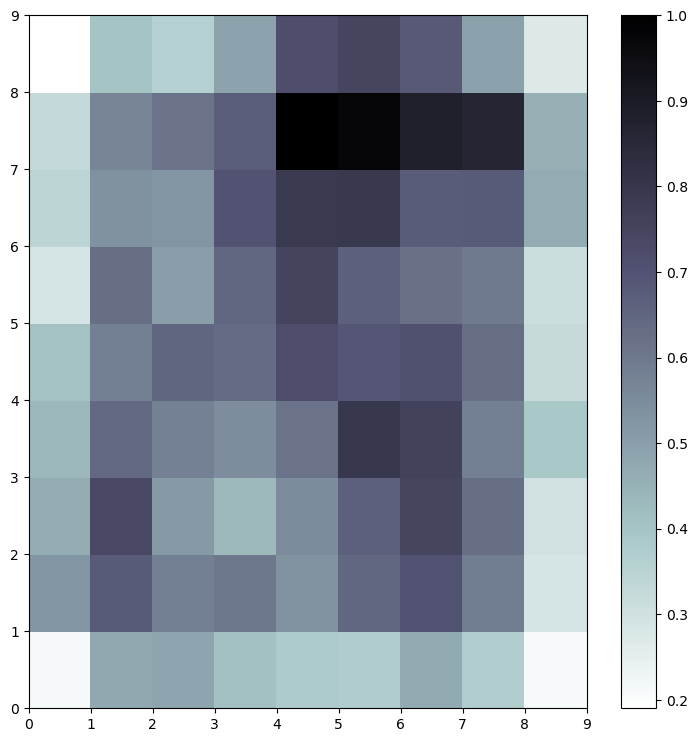

In [13]:
if __name__ == "__main__":
    # seed 数据展示
    columns=['area', 'perimeter', 'compactness', 'length_kernel', 'width_kernel',
                   'asymmetry_coefficient', 'length_kernel_groove', 'target']
    data = pd.read_csv('seeds_dataset.txt', 
                    names=columns, 
                   sep='\t+', engine='python')
    labs = data['target'].values
    label_names = {1:'Kama', 2:'Rosa', 3:'Canadian'}
    datas = data[data.columns[:-1]].values
    N,D = np.shape(datas)
    print(N,D)
    
    # 对训练数据进行正则化处理
    datas = feature_normalization(datas)
    
    # SOM的训练
    weights = train_SOM(X=9,Y=9,N_epoch=10000,datas=datas,sigma=1.5,init_weight_fun=weights_PCA)
    
    # 获取UMAP
    UM = get_U_Matrix(weights)
    
    

    plt.figure(figsize=(9, 9))
    plt.pcolor(UM.T, cmap='bone_r')  # plotting the distance map as background
    plt.colorbar()
    '''

    markers = ['o', 's', 'D']
    colors = ['C0', 'C1', 'C2']
    
    for i in range(N):
        x = datas[i]
        w = get_winner_index(x,weights)
        i_lab = labs[i]-1
        
        plt.plot(w[0]+.5, w[1]+.5, markers[i_lab], markerfacecolor='None',
             markeredgecolor=colors[i_lab], markersize=12, markeredgewidth=2)
    '''
    plt.show()
    